In [1]:
import os
import kagglehub
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

# Define the data directories (verify the folder structure; here we assume subdirectories 'train', 'val', 'test')
train_dir = os.path.join(path, 'chest_xray', 'train')
val_dir   = os.path.join(path, 'chest_xray', 'val')
test_dir  = os.path.join(path, 'chest_xray', 'test')


100%|██████████| 2.29G/2.29G [01:46<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
input_size = 224  # typical size for pre-trained models
batch_size = 32

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Mean from ImageNet
                         [0.229, 0.224, 0.225])  # Std from ImageNet
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Set device for training (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Solving the imbalance issue


In [23]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from PIL import Image

# Set random seed for reproducibility
torch.manual_seed(42)

# Handle class imbalance
# Get class counts
class_counts = torch.bincount(torch.tensor(train_dataset.targets))
class_weights = 1. / class_counts
samples_weights = class_weights[train_dataset.targets]

# Create balanced sampler
balanced_sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True
)



Visualising the data distribution

Class Names: ['NORMAL', 'PNEUMONIA']


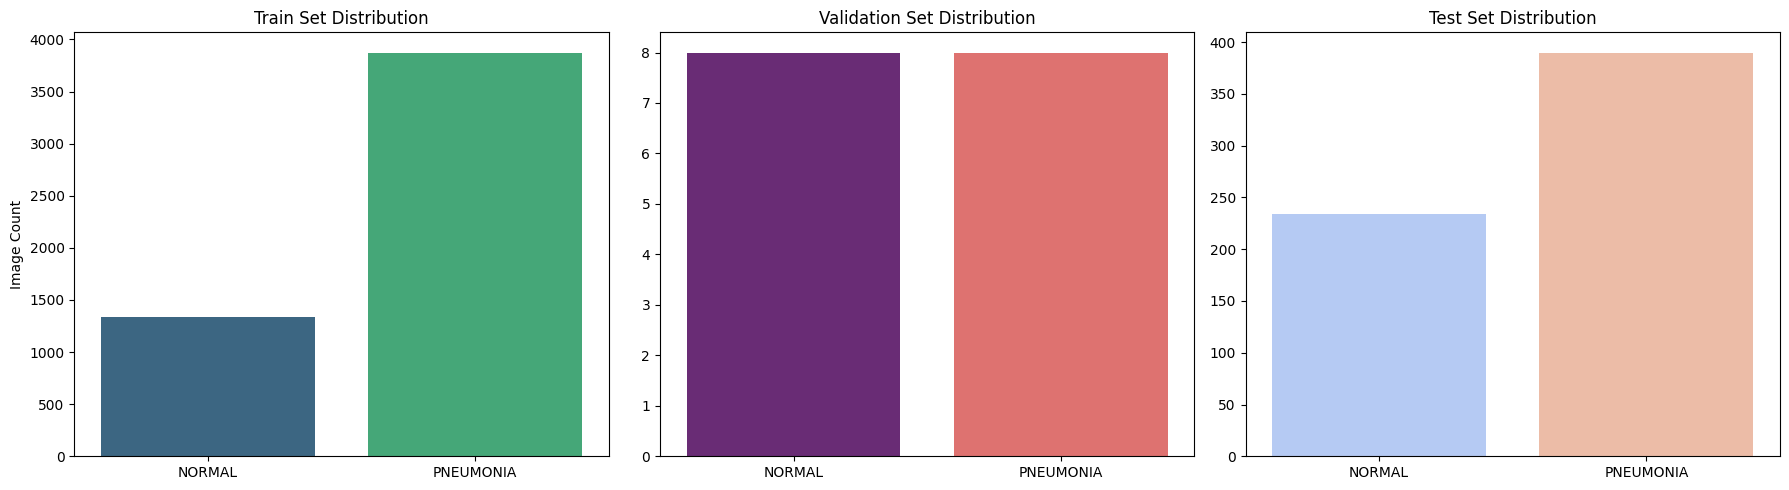

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names
class_names = train_dataset.classes
print("Class Names:", class_names)

# Function to count images per class
def count_images(dataset):
    counts = {class_name: 0 for class_name in class_names}
    for _, label in dataset.samples:  # dataset.samples contains (image_path, label)
        counts[class_names[label]] += 1
    return counts

# Get dataset distributions
train_counts = count_images(train_dataset)
val_counts = count_images(val_dataset)
test_counts = count_images(test_dataset)

# Plot side-by-side bar charts
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0], palette="viridis")
ax[0].set_title("Train Set Distribution")
ax[0].set_ylabel("Image Count")

sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=ax[1], palette="magma")
ax[1].set_title("Validation Set Distribution")

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[2], palette="coolwarm")
ax[2].set_title("Test Set Distribution")

plt.tight_layout()
plt.show()


Generating Random Images

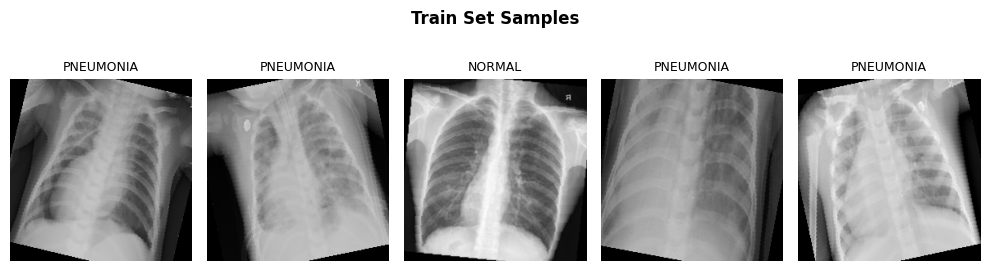

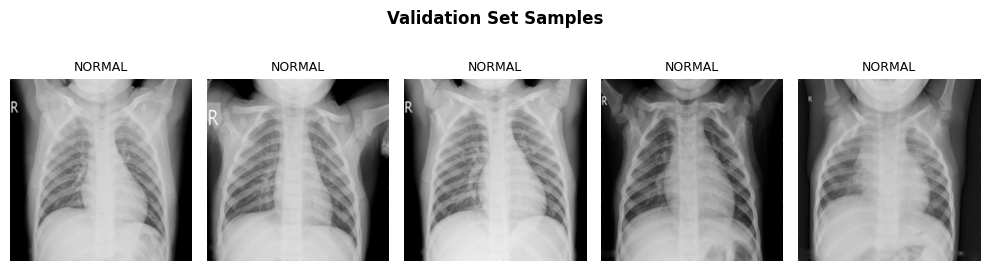

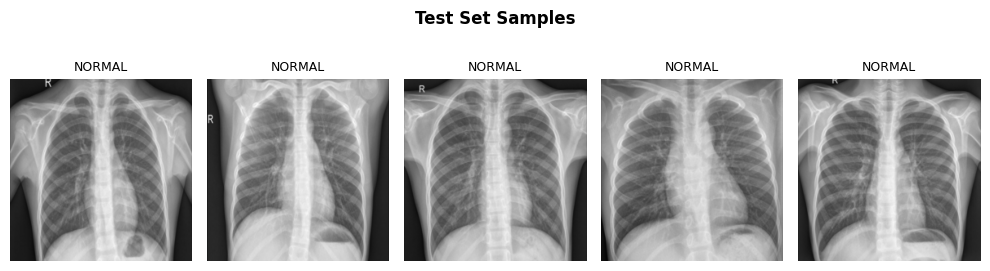

In [6]:
import torch
import matplotlib.pyplot as plt

# Function to unnormalize images (convert back to original form)
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize
    return img.clamp(0, 1)  # Clip values between 0 and 1

# Function to visualize images side by side
def visualize_images(dataloader, dataset_name, class_names, num_images=5):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))  # Smaller size
    for i in range(num_images):
        img = unnormalize(images[i]).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i].item()], fontsize=9)
        axes[i].axis("off")

    plt.suptitle(f"{dataset_name} Samples", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Display random samples from Train, Validation, and Test sets
visualize_images(train_loader, "Train Set", train_dataset.classes, num_images=5)
visualize_images(val_loader, "Validation Set", val_dataset.classes, num_images=5)
visualize_images(test_loader, "Test Set", test_dataset.classes, num_images=5)


In [7]:
import time

Model trained from scratch

CNN

In [26]:
from tqdm import tqdm  # For progress bar
# Define Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * (input_size // 8) * (input_size // 8), 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model, loss, optimizer
model = CustomCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Function to evaluate model (validation and test)
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = corrects.double() / total
    return avg_loss, avg_acc

# Training loop with progress bar
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0

    # Using tqdm for the progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        corrects += torch.sum(preds == labels)
        total += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix(loss=running_loss / total, acc=(corrects.double() / total).item())

    # Calculate training loss and accuracy
    train_loss = running_loss / total
    train_acc = corrects.double() / total

    # Evaluate on validation set
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/5: 100%|██████████| 163/163 [01:29<00:00,  1.83it/s, acc=0.859, loss=0.337]


Epoch 1/5 - Train Loss: 0.3372, Train Acc: 0.8591 | Val Loss: 0.6651, Val Acc: 0.6875


Epoch 2/5: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s, acc=0.93, loss=0.183]


Epoch 2/5 - Train Loss: 0.1825, Train Acc: 0.9298 | Val Loss: 0.5625, Val Acc: 0.5625


Epoch 3/5: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s, acc=0.947, loss=0.148]


Epoch 3/5 - Train Loss: 0.1482, Train Acc: 0.9471 | Val Loss: 0.9903, Val Acc: 0.5625


Epoch 4/5: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s, acc=0.953, loss=0.138]


Epoch 4/5 - Train Loss: 0.1381, Train Acc: 0.9534 | Val Loss: 1.1489, Val Acc: 0.5625


Epoch 5/5: 100%|██████████| 163/163 [01:17<00:00,  2.09it/s, acc=0.951, loss=0.132]


Epoch 5/5 - Train Loss: 0.1320, Train Acc: 0.9509 | Val Loss: 0.9650, Val Acc: 0.5625
Test Loss: 0.7172, Test Accuracy: 0.7724


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style for better aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Manually defined metrics based on your training output
num_epochs = 5
train_losses = [0.3122, 0.1911, 0.1705, 0.1511, 0.1448]
val_losses   = [0.8149, 0.7679, 1.0286, 0.8894, 0.8231]
train_accuracies = [0.8623, 0.9247, 0.9348, 0.9410, 0.9457]
val_accuracies   = [0.5625, 0.6250, 0.6250, 0.6250, 0.5625]
test_acc  = 0.7676

# Define epoch indices for x-axis
epochs = range(1, num_epochs + 1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Loss Curves on the first subplot
ax1.plot(epochs, train_losses, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Loss")
ax1.plot(epochs, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Loss")
ax1.set_xlabel("Epochs", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Training vs. Validation Loss", fontsize=16, fontweight='bold')
ax1.set_xticks(list(epochs))
ax1.legend(fontsize=12)

# Plot Accuracy Curves on the second subplot
ax2.plot(epochs, train_accuracies, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Accuracy")
ax2.plot(epochs, val_accuracies, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Accuracy")
ax2.axhline(y=test_acc, color='tab:red', linestyle=':', linewidth=2, label="Test Accuracy")
ax2.set_xlabel("Epochs", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.set_title("Training vs. Validation Accuracy", fontsize=16, fontweight='bold')
ax2.set_xticks(list(epochs))
ax2.set_ylim(0.5, 1.0)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


Pre-Trained models


VGG19 model


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- VGG19 Model Definition -----
vgg_model = models.vgg19(pretrained=True)
for param in vgg_model.features.parameters():
    param.requires_grad = False
num_features = vgg_model.classifier[0].in_features
vgg_model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)
vgg_model = vgg_model.to(device)
criterion_vgg = nn.BCEWithLogitsLoss()
optimizer_vgg = optim.Adam(vgg_model.classifier.parameters(), lr=1e-4)

# Assume that train_loader, val_loader, test_loader are defined in previous cells.

# Evaluation function for loss and accuracy
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = corrects.double() / total
    return avg_loss, avg_acc

# Training function that tracks train, validation, and test metrics
def train_model_vgg(model, criterion, optimizer, train_loader, val_loader, test_loader, device, num_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    test_losses, test_accs = [], []
    total_time = 0.0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = corrects.double() / total
        train_losses.append(train_loss)
        train_accs.append(train_acc.item())

        # Evaluate on validation and test sets
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())
        test_losses.append(test_loss)
        test_accs.append(test_acc.item())

        epoch_time = time.time() - start_time
        total_time += epoch_time
        print(f"VGG19 - Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} sec")

    avg_epoch_time = total_time / num_epochs
    print(f"VGG19 - Epochs per second: {1/avg_epoch_time:.4f}")

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

# Train the model and capture metrics
num_epochs = 5
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = train_model_vgg(
    vgg_model, criterion_vgg, optimizer_vgg, train_loader, val_loader, test_loader, device, num_epochs
)

# Plotting the curves side by side using subplots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
epochs = range(1, num_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot Loss Curves
ax1.plot(epochs, train_losses, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Loss")
ax1.plot(epochs, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Loss")
ax1.plot(epochs, test_losses, marker='^', linestyle='-.', linewidth=2, markersize=8, color='tab:green', label="Test Loss")
ax1.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax1.set_title("Training, Validation & Test Loss", fontsize=16, fontweight='bold')
ax1.set_xticks(list(epochs))
ax1.legend(fontsize=12)

# Plot Accuracy Curves
ax2.plot(epochs, train_accs, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Accuracy")
ax2.plot(epochs, val_accs, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Accuracy")
ax2.plot(epochs, test_accs, marker='^', linestyle='-.', linewidth=2, markersize=8, color='tab:green', label="Test Accuracy")
ax2.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax2.set_ylabel("Accuracy", fontsize=14, fontweight='bold')
ax2.set_title("Training, Validation & Test Accuracy", fontsize=16, fontweight='bold')
ax2.set_xticks(list(epochs))
ax2.set_ylim(0.0, 1.0)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 124MB/s]
Epoch 1/5: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]


VGG19 - Epoch 1/5 - Train Loss: 0.1504, Train Acc: 0.9337 | Val Loss: 0.1120, Val Acc: 1.0000 | Test Loss: 0.3920, Test Acc: 0.8446 | Epoch Time: 93.18 sec


Epoch 2/5: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]


VGG19 - Epoch 2/5 - Train Loss: 0.0839, Train Acc: 0.9674 | Val Loss: 0.0902, Val Acc: 1.0000 | Test Loss: 0.5952, Test Acc: 0.8237 | Epoch Time: 93.15 sec


Epoch 3/5: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]


VGG19 - Epoch 3/5 - Train Loss: 0.0764, Train Acc: 0.9693 | Val Loss: 0.2126, Val Acc: 0.8750 | Test Loss: 0.7867, Test Acc: 0.8013 | Epoch Time: 93.54 sec


Epoch 4/5: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]


VGG19 - Epoch 4/5 - Train Loss: 0.0698, Train Acc: 0.9741 | Val Loss: 0.2190, Val Acc: 0.8750 | Test Loss: 0.8568, Test Acc: 0.7949 | Epoch Time: 93.27 sec


Epoch 5/5: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]


VGG19 - Epoch 5/5 - Train Loss: 0.0698, Train Acc: 0.9737 | Val Loss: 0.1699, Val Acc: 0.9375 | Test Loss: 0.7689, Test Acc: 0.8109 | Epoch Time: 93.13 sec
VGG19 - Epochs per second: 0.0107


ResNet50 Model

Epoch 1/5: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


ResNet50 - Epoch 1/5 - Train Loss: 0.3698, Train Acc: 0.8407 | Val Loss: 0.4575, Val Acc: 0.7500 | Test Loss: 0.4125, Test Acc: 0.7981 | Epoch Time: 88.94 sec


Epoch 2/5: 100%|██████████| 163/163 [01:24<00:00,  1.93it/s]


ResNet50 - Epoch 2/5 - Train Loss: 0.2226, Train Acc: 0.9128 | Val Loss: 0.2970, Val Acc: 0.9375 | Test Loss: 0.3409, Test Acc: 0.8446 | Epoch Time: 93.48 sec


Epoch 3/5: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


ResNet50 - Epoch 3/5 - Train Loss: 0.1840, Train Acc: 0.9277 | Val Loss: 0.3419, Val Acc: 0.8125 | Test Loss: 0.3724, Test Acc: 0.8478 | Epoch Time: 88.42 sec


Epoch 4/5: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


ResNet50 - Epoch 4/5 - Train Loss: 0.1737, Train Acc: 0.9319 | Val Loss: 0.3018, Val Acc: 0.8125 | Test Loss: 0.3537, Test Acc: 0.8413 | Epoch Time: 87.92 sec


Epoch 5/5: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


ResNet50 - Epoch 5/5 - Train Loss: 0.1694, Train Acc: 0.9331 | Val Loss: 0.3164, Val Acc: 0.8125 | Test Loss: 0.3725, Test Acc: 0.8526 | Epoch Time: 87.53 sec
ResNet50 - Epochs per second: 0.0112


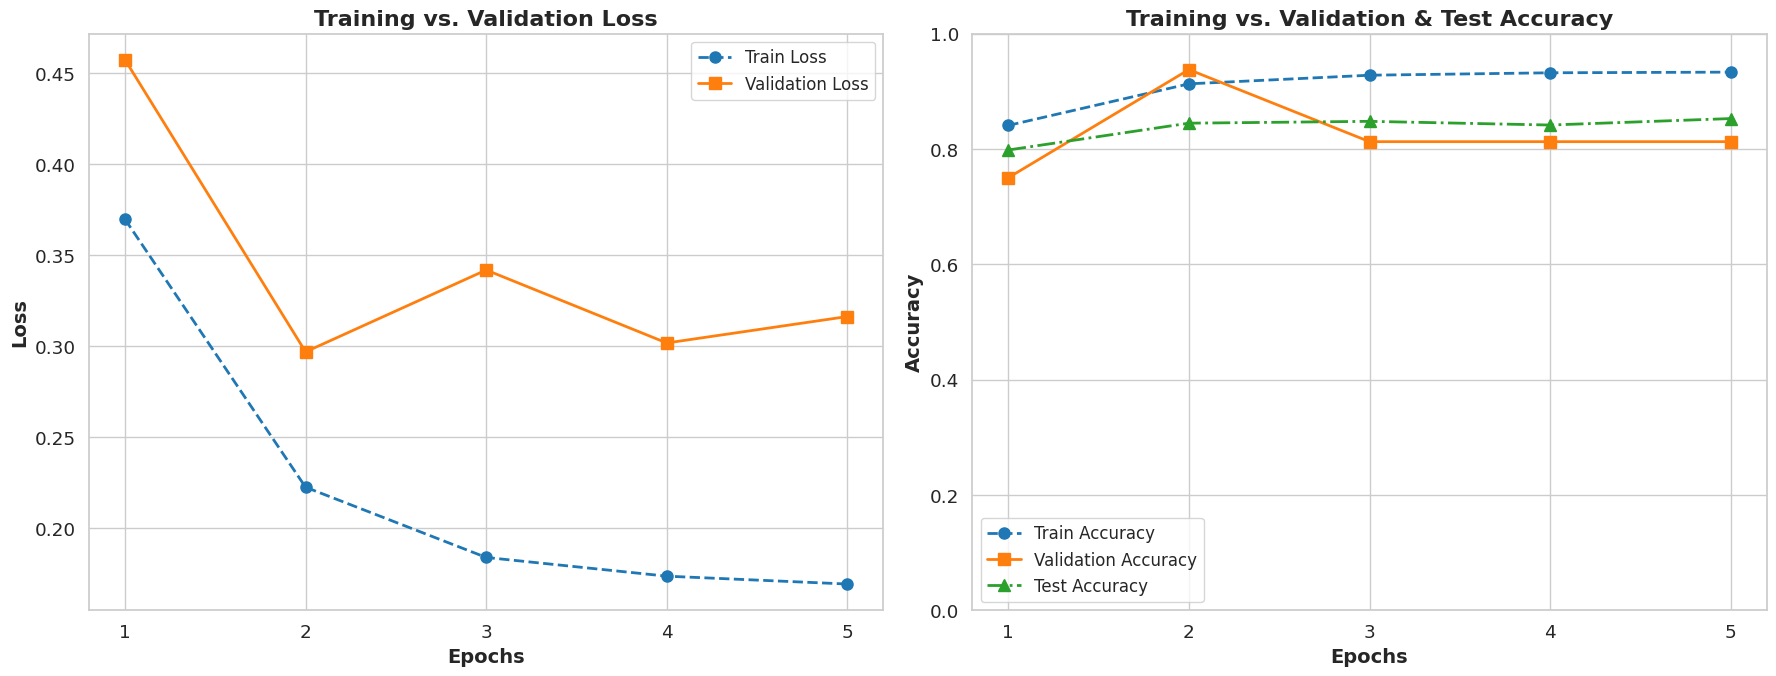

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- ResNet50 Model Definition -----
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
    param.requires_grad = False
num_features_resnet = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_features_resnet, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)
resnet_model = resnet_model.to(device)
criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=1e-4)

# Define evaluation function for computing loss and accuracy
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = corrects.double() / total
    return avg_loss, avg_acc

# Modified training function for ResNet50 that tracks metrics and calculates test loss (for printing only)
def train_model_resnet(model, criterion, optimizer, train_loader, val_loader, test_loader, device, num_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    test_losses, test_accs = [], []
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)

        # Calculate training metrics
        train_loss = running_loss / total
        train_acc = corrects.double() / total
        train_losses.append(train_loss)
        train_accs.append(train_acc.item())

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        # Evaluate on test set (for printing and test accuracy plot only)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc.item())

        epoch_time = time.time() - start_time
        total_time += epoch_time

        print(f"ResNet50 - Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} sec")

    avg_epoch_time = total_time / num_epochs
    print(f"ResNet50 - Epochs per second: {1/avg_epoch_time:.4f}")

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

# Train the ResNet50 model and capture metrics
num_epochs = 5
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = train_model_resnet(
    resnet_model, criterion_resnet, optimizer_resnet, train_loader, val_loader, test_loader, device, num_epochs
)

# Plotting the curves side by side with Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
epochs = range(1, num_epochs + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot Loss Curves (only training and validation loss)
ax1.plot(epochs, train_losses, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Loss")
ax1.plot(epochs, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Loss")
ax1.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax1.set_title("Training vs. Validation Loss", fontsize=16, fontweight='bold')
ax1.set_xticks(list(epochs))
ax1.legend(fontsize=12)

# Plot Accuracy Curves (including test accuracy)
ax2.plot(epochs, train_accs, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Accuracy")
ax2.plot(epochs, val_accs, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Accuracy")
ax2.plot(epochs, test_accs, marker='^', linestyle='-.', linewidth=2, markersize=8, color='tab:green', label="Test Accuracy")
ax2.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax2.set_ylabel("Accuracy", fontsize=14, fontweight='bold')
ax2.set_title("Training vs. Validation & Test Accuracy", fontsize=16, fontweight='bold')
ax2.set_xticks(list(epochs))
ax2.set_ylim(0.0, 1.0)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


EfficientNetB3 Model

In [22]:

from torchvision.models import efficientnet_b3

# ----- EfficientNetB3 Model Setup -----
efficientnet_model = efficientnet_b3(pretrained=True)
for param in efficientnet_model.features.parameters():
    param.requires_grad = False
num_features_eff = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Linear(num_features_eff, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)
efficientnet_model = efficientnet_model.to(device)
criterion_eff = nn.BCEWithLogitsLoss()
optimizer_eff = optim.Adam(efficientnet_model.classifier.parameters(), lr=1e-4)

# Evaluation function: computes average loss and accuracy over a dataloader.
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = corrects.double() / total
    return avg_loss, avg_acc

# Extended training function for EfficientNetB3:
def train_model_efficientnet_extended(model, criterion, optimizer, train_loader, val_loader, test_loader, device, num_epochs):
    # Lists to store metrics per epoch
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    test_losses, test_accs = [], []
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        # Training loop with progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)

        # Calculate training metrics
        train_loss = running_loss / total
        train_acc = corrects.double() / total
        train_losses.append(train_loss)
        train_accs.append(train_acc.item())

        # Evaluate on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        # Evaluate on test set (calculated for printing and accuracy plotting)
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc.item())

        epoch_time = time.time() - start_time
        total_time += epoch_time

        print(f"EfficientNetB3 - Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} sec")

    avg_epoch_time = total_time / num_epochs
    print(f"EfficientNetB3 - Epochs per second: {1/avg_epoch_time:.4f}")

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

# Set number of epochs and train the model
num_epochs = 5
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = train_model_efficientnet_extended(
    efficientnet_model, criterion_eff, optimizer_eff, train_loader, val_loader, test_loader, device, num_epochs
)

# Plotting the metrics using Seaborn style for a polished look
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
epochs = range(1, num_epochs + 1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left subplot: Plot Training and Validation Loss (do not include test loss)
ax1.plot(epochs, train_losses, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Loss")
ax1.plot(epochs, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Loss")
ax1.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax1.set_title("EfficientNetB3: Training vs. Validation Loss", fontsize=16, fontweight='bold')
ax1.set_xticks(list(epochs))
ax1.legend(fontsize=12)

# Right subplot: Plot Training, Validation, and Test Accuracy
ax2.plot(epochs, train_accs, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Accuracy")
ax2.plot(epochs, val_accs, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Accuracy")
ax2.plot(epochs, test_accs, marker='^', linestyle='-.', linewidth=2, markersize=8, color='tab:green', label="Test Accuracy")
ax2.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax2.set_ylabel("Accuracy", fontsize=14, fontweight='bold')
ax2.set_title("EfficientNetB3: Training vs. Validation & Test Accuracy", fontsize=16, fontweight='bold')
ax2.set_xticks(list(epochs))
ax2.set_ylim(0.0, 1.0)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 100MB/s] 
Epoch 1/5: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]


EfficientNetB3 - Epoch 1/5 - Train Loss: 0.4305, Train Acc: 0.8138 | Val Loss: 0.3918, Val Acc: 0.8125 | Test Loss: 0.4021, Test Acc: 0.8494 | Epoch Time: 93.35 sec


Epoch 2/5: 100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


EfficientNetB3 - Epoch 2/5 - Train Loss: 0.2515, Train Acc: 0.9082 | Val Loss: 0.3122, Val Acc: 0.8750 | Test Loss: 0.3376, Test Acc: 0.8622 | Epoch Time: 88.31 sec


Epoch 3/5: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


EfficientNetB3 - Epoch 3/5 - Train Loss: 0.2113, Train Acc: 0.9158 | Val Loss: 0.2998, Val Acc: 0.8750 | Test Loss: 0.3272, Test Acc: 0.8670 | Epoch Time: 88.36 sec


Epoch 4/5: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s]


EfficientNetB3 - Epoch 4/5 - Train Loss: 0.2057, Train Acc: 0.9168 | Val Loss: 0.2654, Val Acc: 0.8750 | Test Loss: 0.3173, Test Acc: 0.8686 | Epoch Time: 86.14 sec


Epoch 5/5: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


EfficientNetB3 - Epoch 5/5 - Train Loss: 0.1826, Train Acc: 0.9314 | Val Loss: 0.2936, Val Acc: 0.8750 | Test Loss: 0.3170, Test Acc: 0.8718 | Epoch Time: 86.91 sec
EfficientNetB3 - Epochs per second: 0.0113


 DenseNet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 61.5MB/s]
Epoch 1/5: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]


DenseNet121 - Epoch 1/5 - Train Loss: 0.4474, Train Acc: 0.7845 | Val Loss: 0.4997, Val Acc: 0.6875 | Test Loss: 0.4659, Test Acc: 0.7564 | Epoch Time: 89.69 sec


Epoch 2/5: 100%|██████████| 163/163 [01:25<00:00,  1.91it/s]


DenseNet121 - Epoch 2/5 - Train Loss: 0.2688, Train Acc: 0.9016 | Val Loss: 0.3633, Val Acc: 0.7500 | Test Loss: 0.3977, Test Acc: 0.7981 | Epoch Time: 95.81 sec


Epoch 3/5: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


DenseNet121 - Epoch 3/5 - Train Loss: 0.2060, Train Acc: 0.9283 | Val Loss: 0.2385, Val Acc: 1.0000 | Test Loss: 0.3426, Test Acc: 0.8542 | Epoch Time: 88.88 sec


Epoch 4/5: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


DenseNet121 - Epoch 4/5 - Train Loss: 0.1888, Train Acc: 0.9291 | Val Loss: 0.2112, Val Acc: 1.0000 | Test Loss: 0.3358, Test Acc: 0.8590 | Epoch Time: 88.71 sec


Epoch 5/5: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


DenseNet121 - Epoch 5/5 - Train Loss: 0.1718, Train Acc: 0.9340 | Val Loss: 0.2197, Val Acc: 1.0000 | Test Loss: 0.3618, Test Acc: 0.8381 | Epoch Time: 87.98 sec
DenseNet121 - Epochs per second: 0.0111


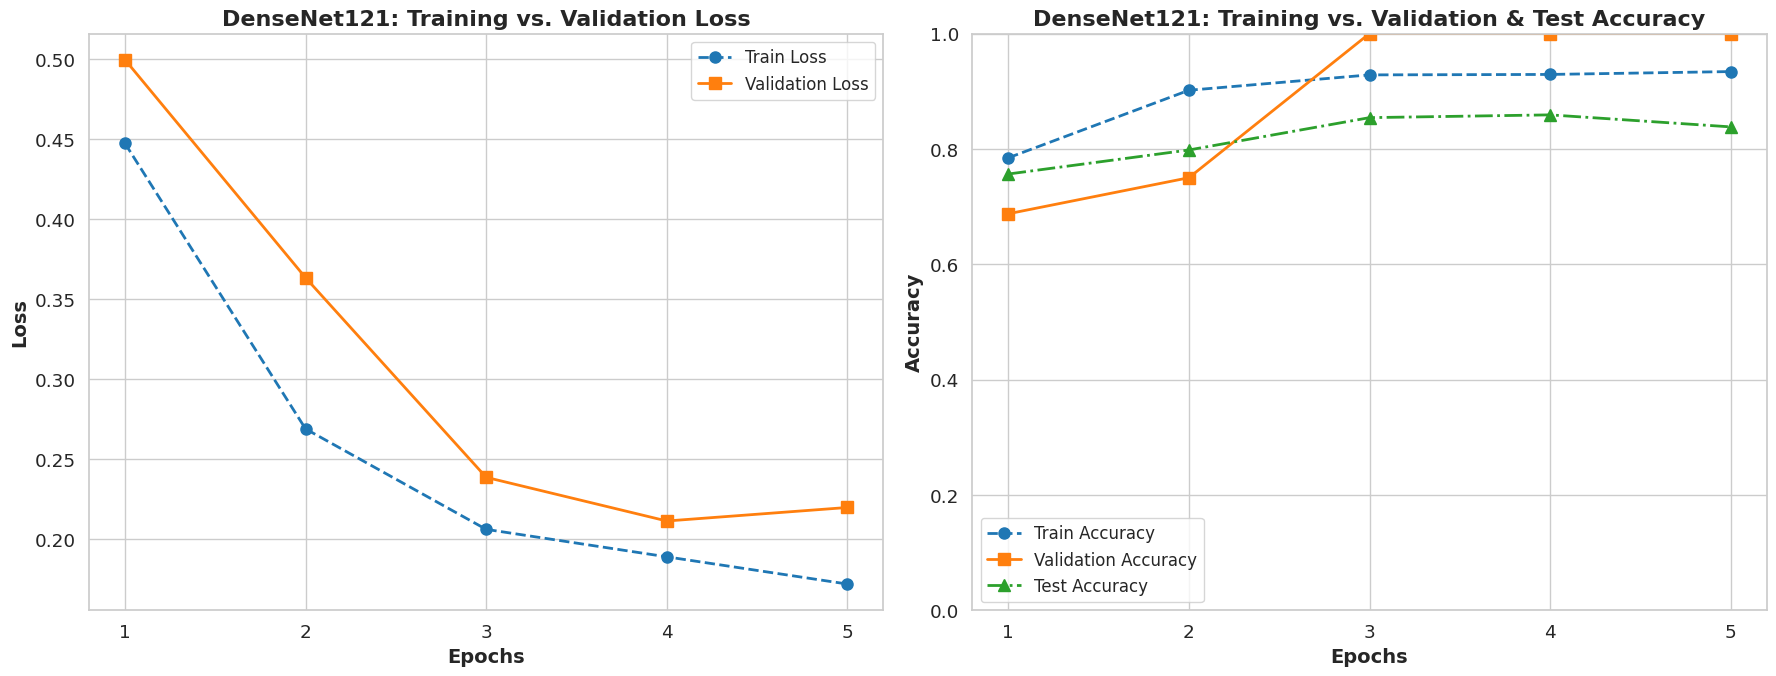

In [25]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ----- DenseNet121 Model Setup -----
densenet_model = models.densenet121(pretrained=True)
for param in densenet_model.features.parameters():
    param.requires_grad = False
num_features_dense = densenet_model.classifier.in_features
densenet_model.classifier = nn.Sequential(
    nn.Linear(num_features_dense, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)
densenet_model = densenet_model.to(device)
criterion_dense = nn.BCEWithLogitsLoss()
optimizer_dense = optim.Adam(densenet_model.classifier.parameters(), lr=1e-4)

# Function to evaluate model performance
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = corrects.double() / total
    return avg_loss, avg_acc

# Extended training function for DenseNet121
def train_model_densenet_extended(model, criterion, optimizer, train_loader, val_loader, test_loader, device, num_epochs):
    # Lists to store metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    test_losses, test_accs = [], []
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        # Training loop with progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            corrects += torch.sum(preds == labels)
            total += labels.size(0)

        # Compute training metrics
        train_loss = running_loss / total
        train_acc = corrects.double() / total
        train_losses.append(train_loss)
        train_accs.append(train_acc.item())

        # Evaluate on validation and test sets
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc.item())

        epoch_time = time.time() - start_time
        total_time += epoch_time

        print(f"DenseNet121 - Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f} | "
              f"Epoch Time: {epoch_time:.2f} sec")

    avg_epoch_time = total_time / num_epochs
    print(f"DenseNet121 - Epochs per second: {1/avg_epoch_time:.4f}")

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

# Set number of epochs and train the model
num_epochs = 5
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = train_model_densenet_extended(
    densenet_model, criterion_dense, optimizer_dense, train_loader, val_loader, test_loader, device, num_epochs
)

# ---- Plot Metrics ----
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
epochs = range(1, num_epochs + 1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left subplot: Plot Training and Validation Loss (do not include test loss)
ax1.plot(epochs, train_losses, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Loss")
ax1.plot(epochs, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Loss")
ax1.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax1.set_title("DenseNet121: Training vs. Validation Loss", fontsize=16, fontweight='bold')
ax1.set_xticks(list(epochs))
ax1.legend(fontsize=12)

# Right subplot: Plot Training, Validation, and Test Accuracy
ax2.plot(epochs, train_accs, marker='o', linestyle='--', linewidth=2, markersize=8, color='tab:blue', label="Train Accuracy")
ax2.plot(epochs, val_accs, marker='s', linestyle='-', linewidth=2, markersize=8, color='tab:orange', label="Validation Accuracy")
ax2.plot(epochs, test_accs, marker='^', linestyle='-.', linewidth=2, markersize=8, color='tab:green', label="Test Accuracy")
ax2.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax2.set_ylabel("Accuracy", fontsize=14, fontweight='bold')
ax2.set_title("DenseNet121: Training vs. Validation & Test Accuracy", fontsize=16, fontweight='bold')
ax2.set_xticks(list(epochs))
ax2.set_ylim(0.0, 1.0)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()


Evaluating all the models

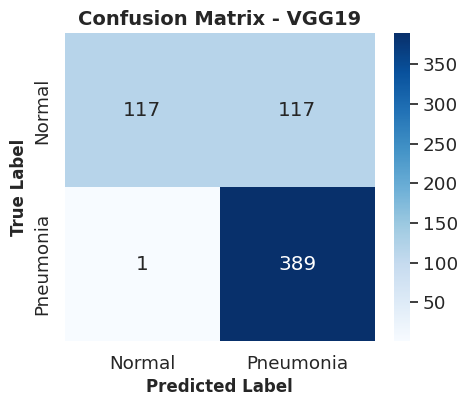


Classification Report for VGG19:

              precision    recall  f1-score   support

      Normal       0.99      0.50      0.66       234
   Pneumonia       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624



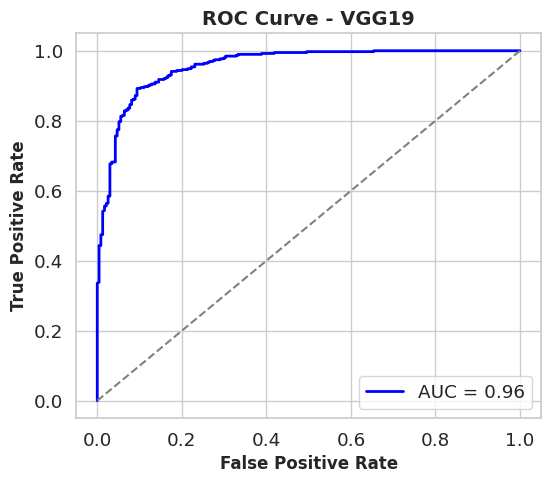

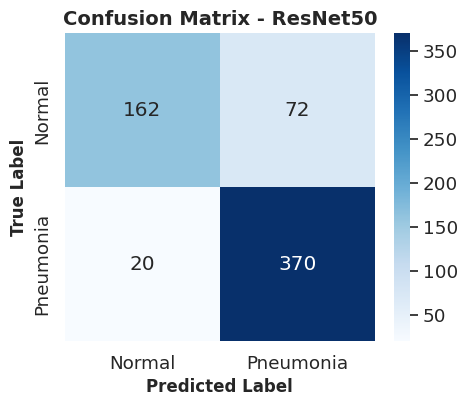


Classification Report for ResNet50:

              precision    recall  f1-score   support

      Normal       0.89      0.69      0.78       234
   Pneumonia       0.84      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



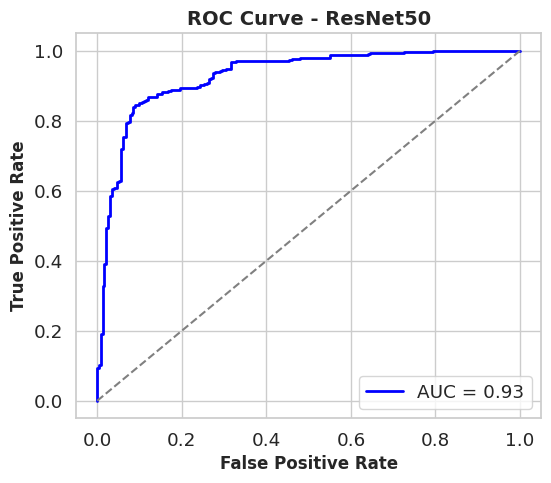


Classification Report for EfficientNetB3:

              precision    recall  f1-score   support

      Normal       0.87      0.77      0.82       234
   Pneumonia       0.87      0.93      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624



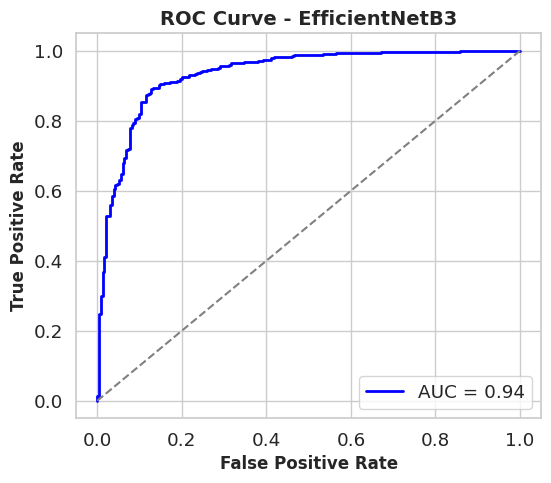

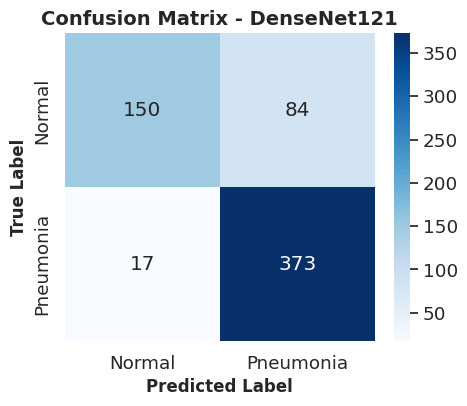


Classification Report for DenseNet121:

              precision    recall  f1-score   support

      Normal       0.90      0.64      0.75       234
   Pneumonia       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.81       624
weighted avg       0.85      0.84      0.83       624



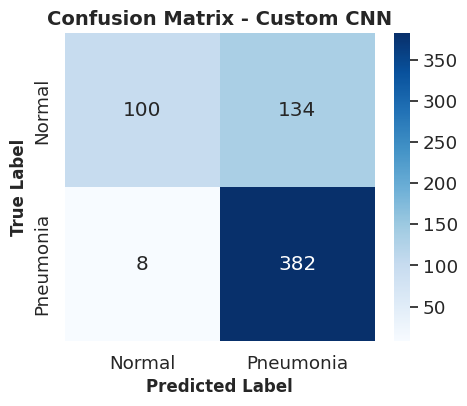


Classification Report for Custom CNN:

              precision    recall  f1-score   support

      Normal       0.93      0.43      0.58       234
   Pneumonia       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.75       624



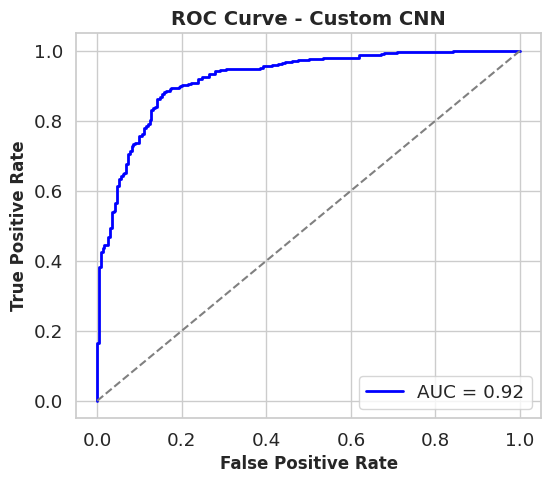

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Function to evaluate a model on the test set
def evaluate_model_metrics(model, test_loader, device, model_name):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are shaped correctly
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()  # Flatten for compatibility

            preds = (probs > 0.5).astype(int)  # Convert probabilities to binary labels
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds)
            y_scores.extend(probs)

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted Label", fontsize=12, fontweight='bold')
    plt.ylabel("True Label", fontsize=12, fontweight='bold')
    plt.title(f"Confusion Matrix - {model_name}", fontsize=14, fontweight='bold')
    plt.show()

    # ---- Classification Report ----
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

    # ---- ROC Curve ----
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold')
    plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold')
    plt.title(f"ROC Curve - {model_name}", fontsize=14, fontweight='bold')
    plt.legend()
    plt.show()

# Evaluate all models on the test set
evaluate_model_metrics(vgg_model, test_loader, device, "VGG19")
evaluate_model_metrics(resnet_model, test_loader, device, "ResNet50")
evaluate_model_metrics(efficientnet_model, test_loader, device, "EfficientNetB3")
evaluate_model_metrics(densenet_model, test_loader, device, "DenseNet121")
evaluate_model_metrics(model, test_loader, device, "Custom CNN")


Ground Truth vs Predictions


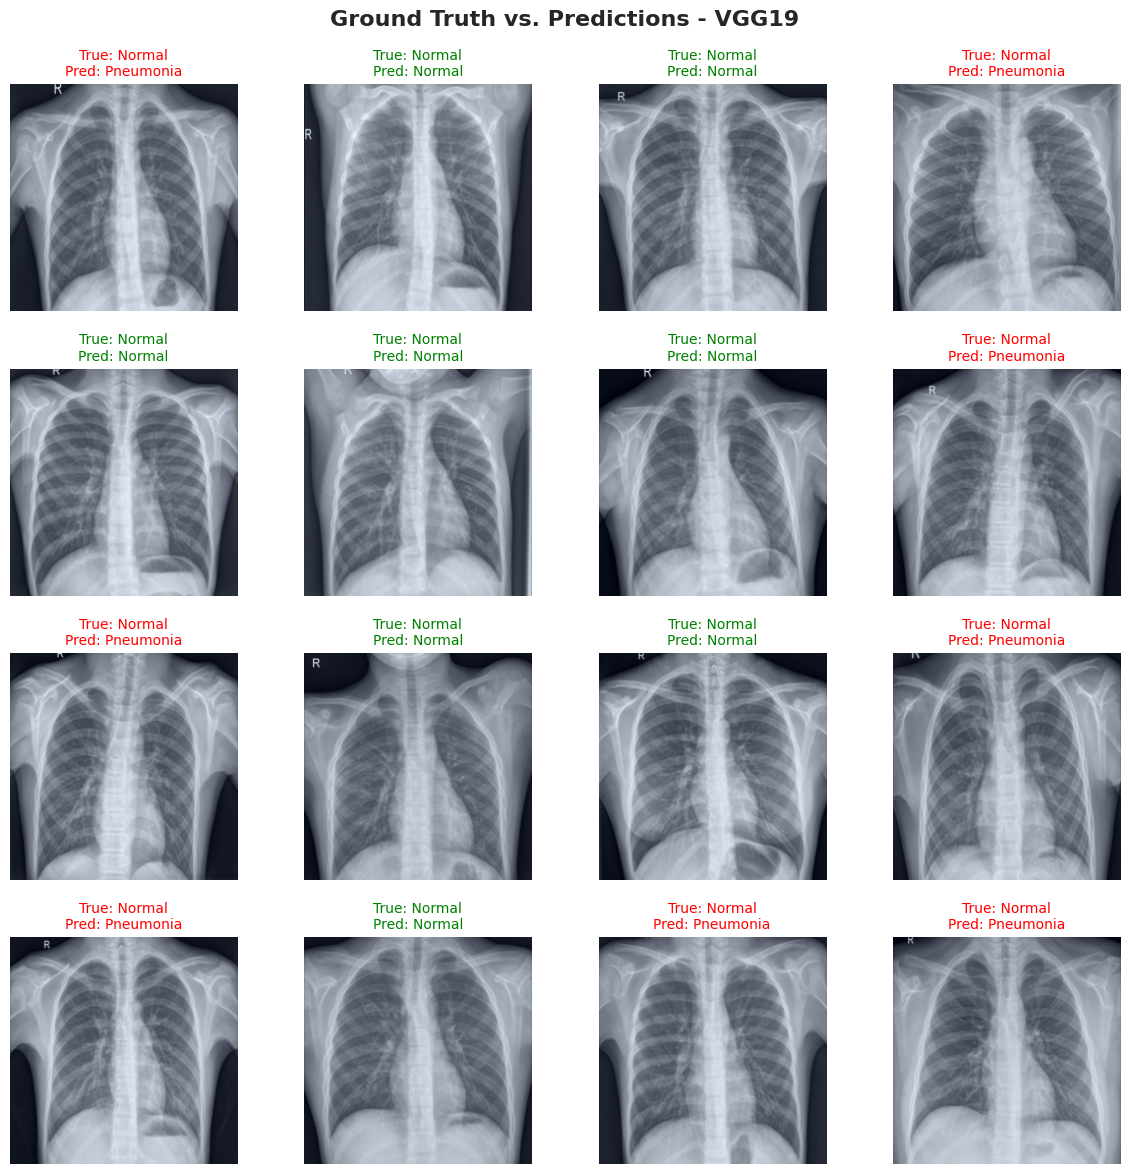

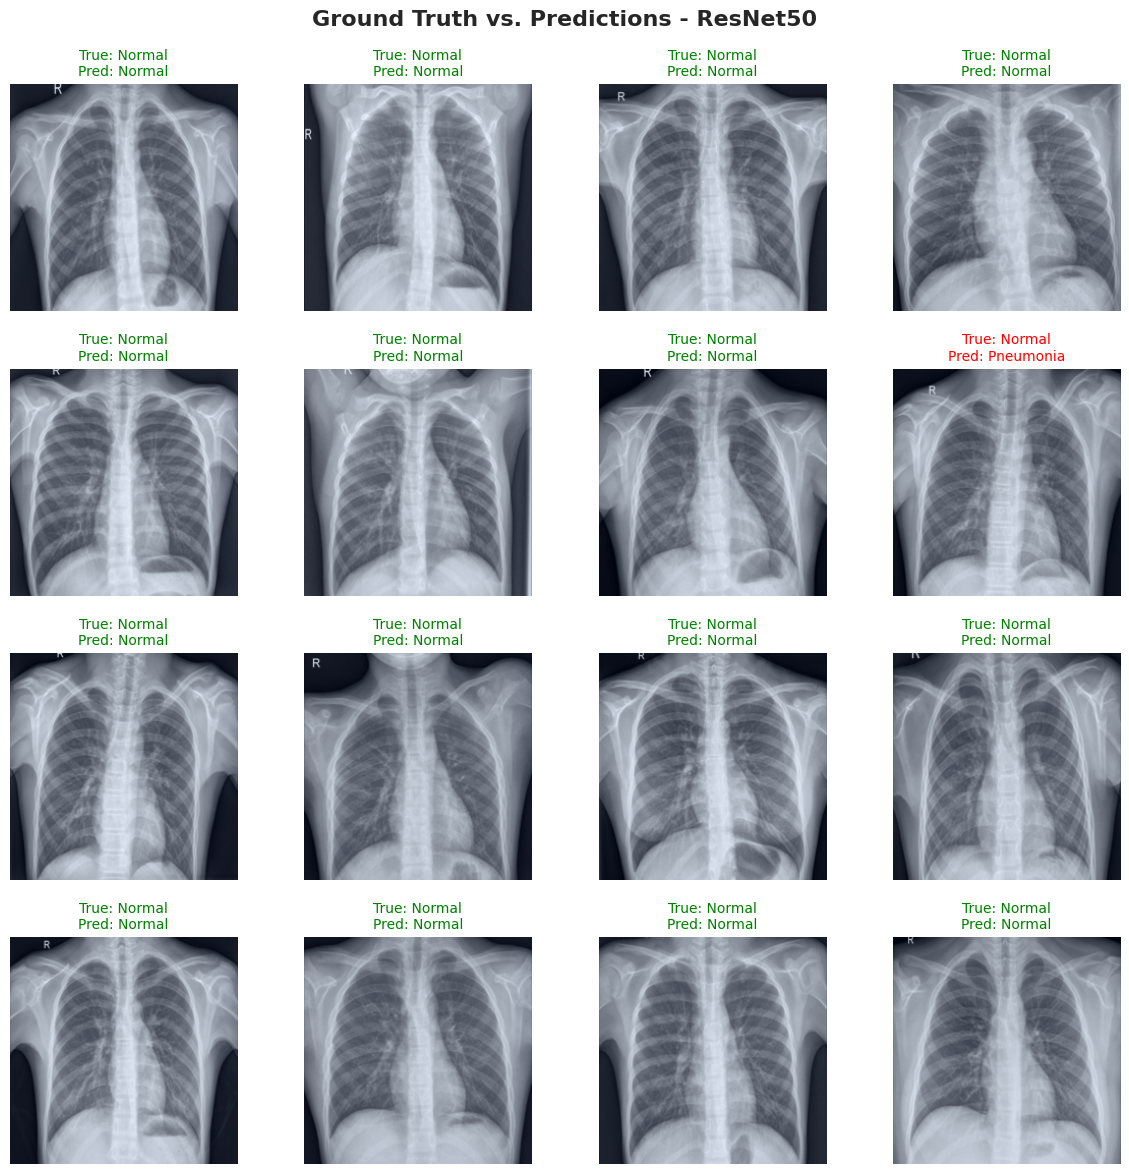

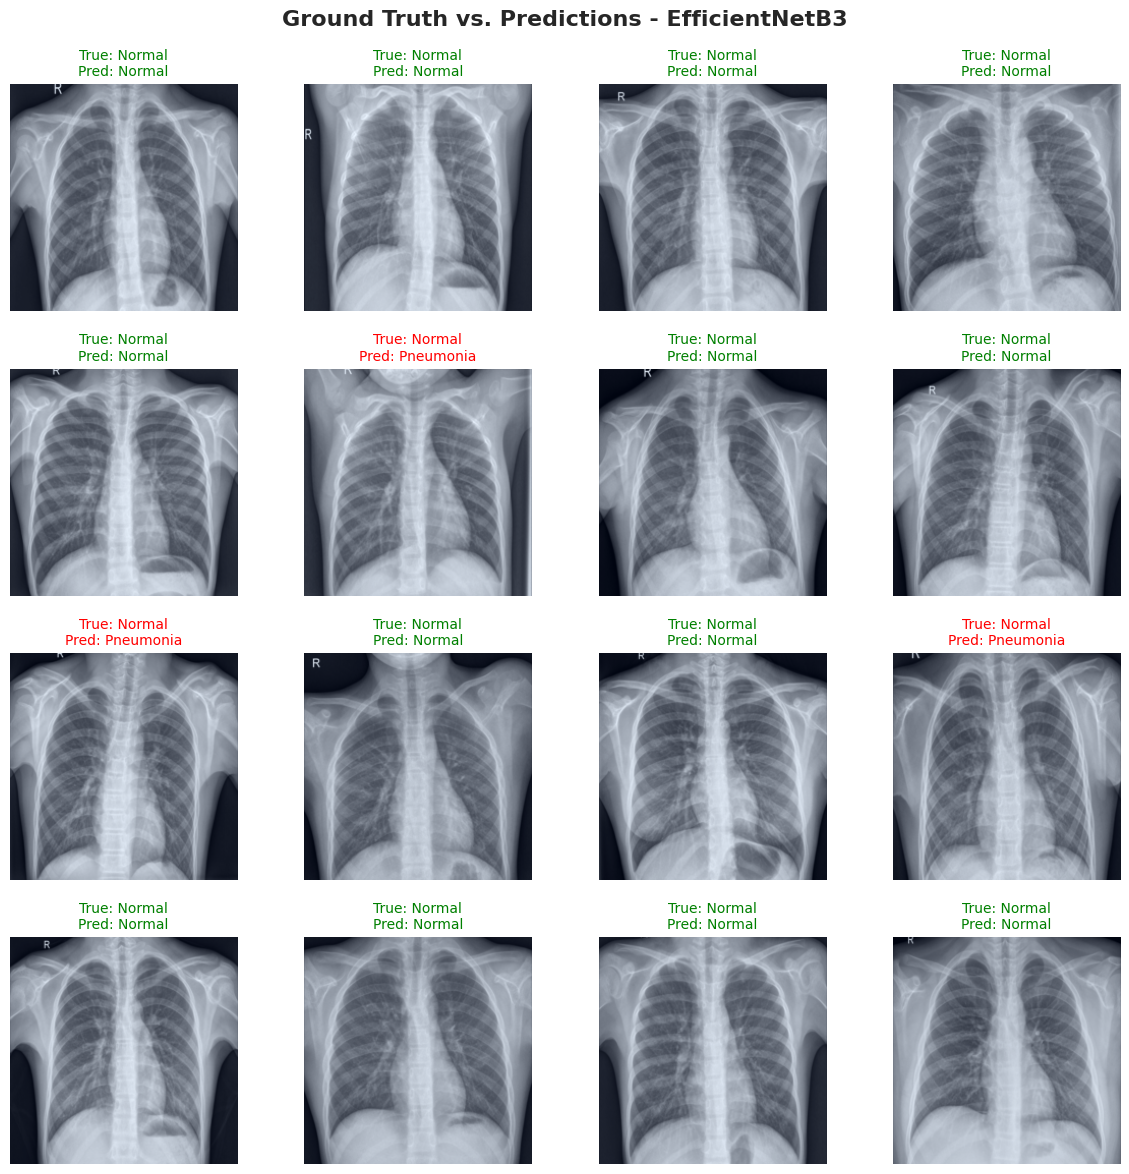

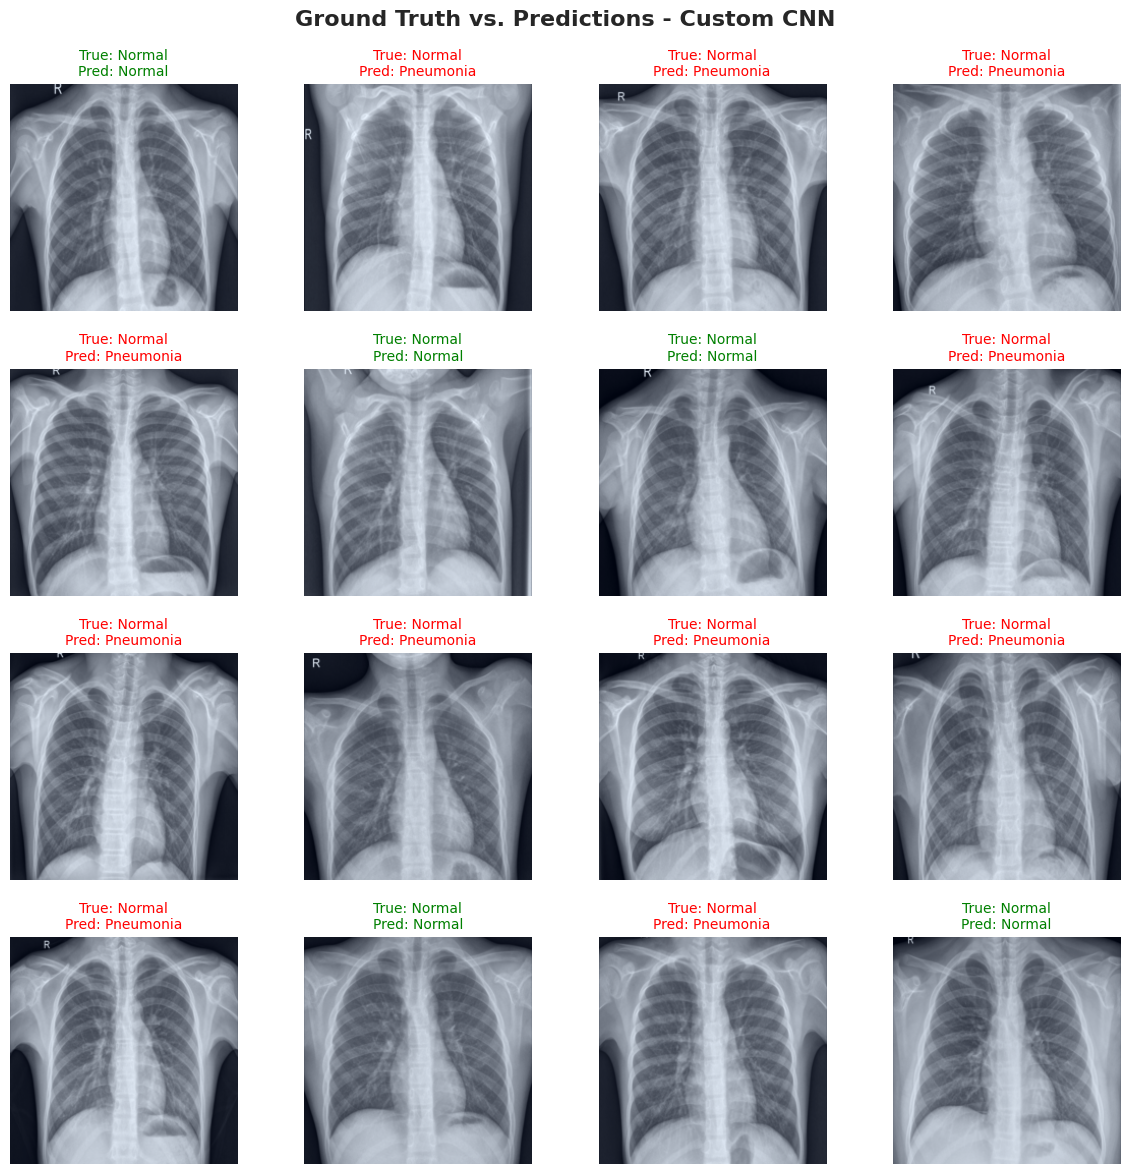

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize ground truth vs. predictions
def visualize_predictions(model, test_loader, device, model_name, num_images=16):
    model.eval()
    images, true_labels, pred_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)

            images.extend(inputs.cpu())
            true_labels.extend(labels.cpu().numpy().flatten())
            pred_labels.extend(preds)

            if len(images) >= num_images:
                break

    # Convert images to numpy format for visualization
    images = torch.stack(images[:num_images]).permute(0, 2, 3, 1).numpy()

    # Normalize images if required
    images = (images - images.min()) / (images.max() - images.min())

    # Plot the images with predictions
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i], cmap="gray")  # Adjust cmap if using color images
        true_label = "Pneumonia" if true_labels[i] == 1 else "Normal"
        pred_label = "Pneumonia" if pred_labels[i] == 1 else "Normal"

        # If prediction is incorrect, highlight in red
        color = "green" if true_label == pred_label else "red"

        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        ax.axis("off")

    plt.suptitle(f"Ground Truth vs. Predictions - {model_name}", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Visualize predictions for all models
visualize_predictions(vgg_model, test_loader, device, "VGG19")
visualize_predictions(resnet_model, test_loader, device, "ResNet50")
visualize_predictions(efficientnet_model, test_loader, device, "EfficientNetB3")
visualize_predictions(densenet_model, test_loader, device, "DenseNet121")
visualize_predictions(model, test_loader, device, "Custom CNN")


Finding the Best Model

In [36]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Dictionary to store model scores
model_performance = {}

# Function to evaluate models and return key metrics
def evaluate_model_metrics(model, test_loader, device, model_name):
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy()

            preds = (probs > 0.5).astype(int)  # Convert probabilities to binary labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_scores.extend(probs)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    auc_score = roc_auc_score(y_true, y_scores)
    f1 = classification_report(y_true, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    # Store metrics in dictionary
    model_performance[model_name] = {
        "Accuracy": round(accuracy * 100, 2),
        "AUC": round(auc_score, 3),
        "F1-Score": round(f1, 3),
        "FPR": round(fpr, 3),
        "FNR": round(fnr, 3)
    }

# Evaluate each model
evaluate_model_metrics(vgg_model, test_loader, device, "VGG19")
evaluate_model_metrics(resnet_model, test_loader, device, "ResNet50")
evaluate_model_metrics(efficientnet_model, test_loader, device, "EfficientNetB3")
evaluate_model_metrics(densenet_model, test_loader, device, "DenseNet121")
evaluate_model_metrics(model, test_loader, device, "Custom CNN")

# Print model performance table
import pandas as pd
df = pd.DataFrame(model_performance).T
print(df)

import pandas as pd

# Convert model_performance dictionary to a DataFrame
df = pd.DataFrame(model_performance).T

# Define the best model based on Accuracy, AUC, and F1-Score
best_model_acc = df["Accuracy"].idxmax()  # Model with highest Accuracy
best_model_auc = df["AUC"].idxmax()        # Model with highest AUC
best_model_f1 = df["F1-Score"].idxmax()    # Model with highest F1-score

# Print best models based on different criteria
print(f" Best Model based on Accuracy:{best_model_acc} ({df.loc[best_model_acc, 'Accuracy']}%)")
print(f" Best Model based on AUC:{best_model_auc} (AUC: {df.loc[best_model_auc, 'AUC']})")
print(f"Best Model based on F1-Score:{best_model_f1} (F1-Score: {df.loc[best_model_f1, 'F1-Score']})")

# Overall Best Model - weighted ranking (you can customize weights)
df["Overall Score"] = (df["Accuracy"] * 0.4) + (df["AUC"] * 0.4) + (df["F1-Score"] * 0.2)
best_overall_model = df["Overall Score"].idxmax()

print(f"\n Best Overall Model: {best_overall_model} ")



                Accuracy    AUC  F1-Score    FPR    FNR
VGG19              81.09  0.957     0.792  0.500  0.003
ResNet50           85.26  0.930     0.848  0.308  0.051
EfficientNetB3     87.18  0.935     0.870  0.226  0.069
DenseNet121        83.81  0.937     0.831  0.359  0.044
Custom CNN         77.24  0.922     0.746  0.573  0.021
 Best Model based on Accuracy:EfficientNetB3 (87.18%)
 Best Model based on AUC:VGG19 (AUC: 0.957)
Best Model based on F1-Score:EfficientNetB3 (F1-Score: 0.87)

 Best Overall Model: EfficientNetB3 


Hyperparameter tuning


In [39]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.0 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Function to create models dynamically
def get_model(name, trial):
    if name == "custom_cnn":
        model = CustomCNN()
    elif name == "vgg19":
        model = models.vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 1)
    elif name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 1)
    elif name == "efficientnet":
        model = models.efficientnet_b3(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    elif name == "densenet121":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, 1)

    return model.to(device)

# Function to optimize hyperparameters
def objective(trial, model_name):
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

    model = get_model(model_name, trial)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(3):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return val_loss / len(val_loader)

# **Fix: Rename models list to model_names**
model_names = ["custom_cnn", "vgg19", "resnet50", "efficientnet", "densenet121"]
best_params = {}

for model_name in model_names:
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=3)
    best_params[model_name] = study.best_params

print("\nBest Hyperparameters for Each Model:")
for model, params in best_params.items():
    print(f"{model}: {params}")


[I 2025-03-31 17:56:15,867] A new study created in memory with name: no-name-b384df34-fc29-459c-9139-0a00c535178b
[I 2025-03-31 18:00:36,635] Trial 0 finished with value: 1.2082228660583496 and parameters: {'lr': 9.490858017293005e-05, 'batch_size': 64, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 1.2082228660583496.
[I 2025-03-31 18:04:45,634] Trial 1 finished with value: 0.8162910342216492 and parameters: {'lr': 0.00035006443790696023, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.8162910342216492.
[I 2025-03-31 18:08:56,581] Trial 2 finished with value: 0.536851704120636 and parameters: {'lr': 0.001203332767745592, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.536851704120636.
[I 2025-03-31 18:08:56,582] A new study created in memory with name: no-name-eb9cde7c-d913-4be8-b304-c113233774b7
[I 2025-03-31 18:13:43,125] Trial 0 finished with value: 1.690001130104065 and parameters: {'lr': 0.00028541850600812755, 'batch_size': 32, 'o